# Fully Connected Neural Network

In [39]:
import os
import numpy as np
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [40]:
def f(x, t):
    return (1 - 16  * np.pi**2) * np.sin(x) * np.cos(4 * np.pi * t)

def u(x, t):
    return np.sin(x) * np.cos(4 * np.pi * t)

In [41]:
def gen_data(L, t_end, n):
    x_vals = np.random.rand(n) * L
    t_vals = np.random.rand(n) * t_end
    return (x_vals, t_vals, f(x_vals, t_vals), u(x_vals, t_vals))

In [42]:
# training data generation
t_end = 2

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

In [43]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [44]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
bias_train = torch.ones_like(x_norm)  # Bias column of ones
bias_val = torch.ones_like(x_val_norm)
inputs_train = torch.stack([x_norm, t_norm, bias_train], dim=1)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm, bias_val], dim=1)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1)  # Shape: [N_val, 2]

batch_size = 300
training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [45]:
device = torch.device("cpu")
print("Device: ", device)

Device:  cpu


In [46]:
class FNN(nn.Module):
    # We create FNN as a subclass of nn.Module
    # In this way we import some important methods from the parent class
    def __init__(self, input_size, output_size, hidden_features=64, activation_function=nn.ReLU()):
        super().__init__()
        
        self.activation_function = activation_function
        # In the init method we specify the layers of the neural network
        # ---------------------- student exercise --------------------------------- #
        self.linear_layer_1 = nn.Linear(
            in_features=input_size, out_features=hidden_features, bias=True
        )

        self.linear_layer_2 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_3 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_4 = nn.Linear(
            in_features=hidden_features, out_features=output_size, bias=True
        )
    
        # ---------------------- student exercise --------------------------------- #

    def forward(self, x):
        # The FNN takes a flatten input of dimensions [N, F],
        # where N are the samples and F are the input features (input_size)
        # x is already shaped as [batch_size, 2] from the DataLoader

        # ---------------------- student exercise --------------------------------- #
        x = self.linear_layer_1(x)
        x = self.activation_function(x)
        x = self.linear_layer_2(x)
        x = self.activation_function(x)
        x = self.linear_layer_3(x)
        x = self.activation_function(x)
        x = self.linear_layer_4(x)
        # ---------------------- student exercise --------------------------------- #

        return x

In [47]:
input_size = 3  # x, t, bias
output_size = 2  # f, u;

print(f"The size of input will be = {input_size}")
print(f"The size of output will be = {output_size}")

model = FNN(input_size, output_size, hidden_features=128)
print(model)

The size of input will be = 3
The size of output will be = 2
FNN(
  (activation_function): ReLU()
  (linear_layer_1): Linear(in_features=3, out_features=128, bias=True)
  (linear_layer_2): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_4): Linear(in_features=128, out_features=2, bias=True)
)


In [48]:
model = model.to(device)

In [49]:
batch_size = 128
loss_function = nn.L1Loss()

In [50]:
def train_epoch(model, loader, optimizer, loss_function):
    model.train()  # specifies that the model is in training mode
    losses = []

    for batch in loader:
        inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]

        # 1. Model prediction
        pred = model(inputs)

        # 2. Loss function
        loss = loss_function(pred, target)

        # 3. Append the loss to a list of losses for later analysis. Hint: Use `detach()` and `item()` to extract the loss value from the loss tensor.
        losses.append(loss.detach().item())

        # 4. Backpropagate. Hint: Use the method .backward() to compute the gradients.
        loss.backward()

        # 5. Optimize the weights with the optimizer Hint: Use the method .step() to update the weights.
        optimizer.step()

        # 6. Reset the computed gradients. Hint: Use the method .zero_grad() to reset the gradients.
        optimizer.zero_grad(set_to_none=True)

    return np.array(losses).mean()

In [51]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [52]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "SGD"])
    optimizer_cls = {
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "SGD": torch.optim.SGD,
    }[optimizer_name]

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    activation_name = trial.suggest_categorical("activation", ["ReLU", "Tanh", "SiLU", "ELU"])
    activation_obj = {
        "ReLU": nn.ReLU(),
        "Tanh": nn.Tanh(),
        "SiLU": nn.SiLU(),
        "ELU": nn.ELU(),
    }[activation_name]

    loss_name = trial.suggest_categorical("loss", ["L1", "MSE"])
    loss_function = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}[loss_name]

    model = FNN(input_size, output_size, hidden_features=hidden_size, activation_function=activation_obj)
    model = model.to(device)

    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

    # epochs to use during tuning; override by setting NUM_EPOCHS_TUNE earlier
    num_epochs = int(globals().get("NUM_EPOCHS_TUNE", 50))

    best_val = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_function)
        validation_loss = evaluation(model, validation_loader, loss_function)
        
        if validation_loss < best_val:
            best_val = validation_loss

        # report intermediate result to Optuna and allow pruning
        trial.report(validation_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        if epoch % 10 == 0:
            print(
                "epoch:",
                epoch,
                "\t training loss:",
                np.round(train_loss, 4),
                "\t validation loss:",
                np.round(validation_loss, 4),
            )

    # minimize best validation loss across epochs
    return best_val

In [53]:
# Optuna tuning (edit as needed)
NUM_EPOCHS_TUNE = 200   # epochs per trial (used inside `objective`)
N_TRIALS = 20          # number of trials

# How new params are sampled + how bad trials are stopped early
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

# Track trials (minimize validation loss)
study = optuna.create_study(
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
    study_name="fnn_tuning"
 )

# Run search and print best result
study.optimize(objective, n_trials=N_TRIALS)
print("Best value:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-29 11:55:15,401] A new study created in memory with name: fnn_tuning


epoch: 10 	 training loss: 0.9984 	 validation loss: 0.9483
epoch: 20 	 training loss: 0.9978 	 validation loss: 0.9479
epoch: 30 	 training loss: 0.9974 	 validation loss: 0.9475
epoch: 40 	 training loss: 0.9971 	 validation loss: 0.9472
epoch: 50 	 training loss: 0.9968 	 validation loss: 0.9469
epoch: 60 	 training loss: 0.9966 	 validation loss: 0.9467
epoch: 70 	 training loss: 0.9963 	 validation loss: 0.9465
epoch: 80 	 training loss: 0.9962 	 validation loss: 0.9463
epoch: 90 	 training loss: 0.996 	 validation loss: 0.9462
epoch: 100 	 training loss: 0.9959 	 validation loss: 0.9461
epoch: 110 	 training loss: 0.9957 	 validation loss: 0.9459
epoch: 120 	 training loss: 0.9956 	 validation loss: 0.9458
epoch: 130 	 training loss: 0.9955 	 validation loss: 0.9457
epoch: 140 	 training loss: 0.9954 	 validation loss: 0.9456
epoch: 150 	 training loss: 0.9952 	 validation loss: 0.9455
epoch: 160 	 training loss: 0.9951 	 validation loss: 0.9453
epoch: 170 	 training loss: 0.995 

[I 2026-01-29 11:56:14,195] Trial 0 finished with value: 0.9448774456977844 and parameters: {'hidden_size': 192, 'optimizer': 'SGD', 'learning_rate': 0.0012694403334928418, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 0 with value: 0.9448774456977844.


epoch: 200 	 training loss: 0.9946 	 validation loss: 0.9449
epoch: 10 	 training loss: 0.8136 	 validation loss: 0.7883
epoch: 20 	 training loss: 0.8136 	 validation loss: 0.7883
epoch: 30 	 training loss: 0.8135 	 validation loss: 0.7882
epoch: 40 	 training loss: 0.8135 	 validation loss: 0.7882
epoch: 50 	 training loss: 0.8134 	 validation loss: 0.7882
epoch: 60 	 training loss: 0.8134 	 validation loss: 0.7882
epoch: 70 	 training loss: 0.8134 	 validation loss: 0.7881
epoch: 80 	 training loss: 0.8133 	 validation loss: 0.7881
epoch: 90 	 training loss: 0.8133 	 validation loss: 0.7881
epoch: 100 	 training loss: 0.8133 	 validation loss: 0.788
epoch: 110 	 training loss: 0.8132 	 validation loss: 0.788
epoch: 120 	 training loss: 0.8132 	 validation loss: 0.7879
epoch: 130 	 training loss: 0.8132 	 validation loss: 0.7879
epoch: 140 	 training loss: 0.8132 	 validation loss: 0.7879
epoch: 150 	 training loss: 0.8131 	 validation loss: 0.7878
epoch: 160 	 training loss: 0.8131 

[I 2026-01-29 11:57:09,771] Trial 1 finished with value: 0.7877071350812912 and parameters: {'hidden_size': 32, 'optimizer': 'Adam', 'learning_rate': 6.700139781135937e-05, 'activation': 'ELU', 'loss': 'L1'}. Best is trial 1 with value: 0.7877071350812912.


epoch: 200 	 training loss: 0.813 	 validation loss: 0.7877
epoch: 10 	 training loss: 0.8138 	 validation loss: 0.7882
epoch: 20 	 training loss: 0.8137 	 validation loss: 0.7882
epoch: 30 	 training loss: 0.8137 	 validation loss: 0.7882
epoch: 40 	 training loss: 0.8136 	 validation loss: 0.7881
epoch: 50 	 training loss: 0.8136 	 validation loss: 0.7881
epoch: 60 	 training loss: 0.8136 	 validation loss: 0.7881
epoch: 70 	 training loss: 0.8136 	 validation loss: 0.7881
epoch: 80 	 training loss: 0.8135 	 validation loss: 0.7882
epoch: 90 	 training loss: 0.8135 	 validation loss: 0.788
epoch: 100 	 training loss: 0.8134 	 validation loss: 0.7879
epoch: 110 	 training loss: 0.8134 	 validation loss: 0.7879
epoch: 120 	 training loss: 0.8133 	 validation loss: 0.7878
epoch: 130 	 training loss: 0.8133 	 validation loss: 0.7879
epoch: 140 	 training loss: 0.8131 	 validation loss: 0.7877
epoch: 150 	 training loss: 0.7502 	 validation loss: 0.7195
epoch: 160 	 training loss: 0.6262 

[I 2026-01-29 11:58:17,824] Trial 2 finished with value: 0.051579516381025314 and parameters: {'hidden_size': 224, 'optimizer': 'AdamW', 'learning_rate': 0.000500029746482906, 'activation': 'Tanh', 'loss': 'L1'}. Best is trial 2 with value: 0.051579516381025314.


epoch: 200 	 training loss: 0.0662 	 validation loss: 0.0829
epoch: 10 	 training loss: 0.814 	 validation loss: 0.7885
epoch: 20 	 training loss: 0.8138 	 validation loss: 0.7884
epoch: 30 	 training loss: 0.8138 	 validation loss: 0.7885
epoch: 40 	 training loss: 0.8137 	 validation loss: 0.7885
epoch: 50 	 training loss: 0.8137 	 validation loss: 0.7885
epoch: 60 	 training loss: 0.8136 	 validation loss: 0.7885
epoch: 70 	 training loss: 0.8136 	 validation loss: 0.7885
epoch: 80 	 training loss: 0.8135 	 validation loss: 0.7883
epoch: 90 	 training loss: 0.8134 	 validation loss: 0.7882
epoch: 100 	 training loss: 0.8131 	 validation loss: 0.7881
epoch: 110 	 training loss: 0.8123 	 validation loss: 0.7871
epoch: 120 	 training loss: 0.5181 	 validation loss: 0.4971
epoch: 130 	 training loss: 0.2872 	 validation loss: 0.2848
epoch: 140 	 training loss: 0.1929 	 validation loss: 0.1982
epoch: 150 	 training loss: 0.0747 	 validation loss: 0.0689
epoch: 160 	 training loss: 0.0532

[I 2026-01-29 11:59:16,352] Trial 3 finished with value: 0.037310472689568996 and parameters: {'hidden_size': 32, 'optimizer': 'AdamW', 'learning_rate': 0.0030703873252426656, 'activation': 'Tanh', 'loss': 'L1'}. Best is trial 3 with value: 0.037310472689568996.


epoch: 200 	 training loss: 0.0502 	 validation loss: 0.0447
epoch: 10 	 training loss: 0.8138 	 validation loss: 0.7883
epoch: 20 	 training loss: 0.8137 	 validation loss: 0.7882
epoch: 30 	 training loss: 0.8126 	 validation loss: 0.786
epoch: 40 	 training loss: 0.3791 	 validation loss: 0.3303
epoch: 50 	 training loss: 0.1239 	 validation loss: 0.0865
epoch: 60 	 training loss: 0.0684 	 validation loss: 0.1022
epoch: 70 	 training loss: 0.0733 	 validation loss: 0.0668
epoch: 80 	 training loss: 0.0432 	 validation loss: 0.0387
epoch: 90 	 training loss: 0.0564 	 validation loss: 0.0726
epoch: 100 	 training loss: 0.0549 	 validation loss: 0.032
epoch: 110 	 training loss: 0.0453 	 validation loss: 0.0451
epoch: 120 	 training loss: 0.0451 	 validation loss: 0.0347
epoch: 130 	 training loss: 0.0489 	 validation loss: 0.0478
epoch: 140 	 training loss: 0.0452 	 validation loss: 0.0449
epoch: 150 	 training loss: 0.0379 	 validation loss: 0.03
epoch: 160 	 training loss: 0.0372 	 

[I 2026-01-29 12:00:10,045] Trial 4 finished with value: 0.021724089980125427 and parameters: {'hidden_size': 64, 'optimizer': 'Adam', 'learning_rate': 0.003389400075727431, 'activation': 'Tanh', 'loss': 'L1'}. Best is trial 4 with value: 0.021724089980125427.


epoch: 200 	 training loss: 0.045 	 validation loss: 0.0417
epoch: 10 	 training loss: 0.4395 	 validation loss: 0.3926
epoch: 20 	 training loss: 0.0698 	 validation loss: 0.0947
epoch: 30 	 training loss: 0.0415 	 validation loss: 0.0498
epoch: 40 	 training loss: 0.0378 	 validation loss: 0.0199
epoch: 50 	 training loss: 0.0315 	 validation loss: 0.0401
epoch: 60 	 training loss: 0.0359 	 validation loss: 0.0404
epoch: 70 	 training loss: 0.0481 	 validation loss: 0.0385
epoch: 80 	 training loss: 0.0303 	 validation loss: 0.0331
epoch: 90 	 training loss: 0.041 	 validation loss: 0.0561
epoch: 100 	 training loss: 0.0286 	 validation loss: 0.0342
epoch: 110 	 training loss: 0.0273 	 validation loss: 0.0282
epoch: 120 	 training loss: 0.0336 	 validation loss: 0.0321
epoch: 130 	 training loss: 0.0303 	 validation loss: 0.0556
epoch: 140 	 training loss: 0.0246 	 validation loss: 0.0338
epoch: 150 	 training loss: 0.028 	 validation loss: 0.0254
epoch: 160 	 training loss: 0.0386 	

[I 2026-01-29 12:01:07,965] Trial 5 finished with value: 0.014002584852278233 and parameters: {'hidden_size': 96, 'optimizer': 'Adam', 'learning_rate': 0.004787919262719135, 'activation': 'SiLU', 'loss': 'L1'}. Best is trial 5 with value: 0.014002584852278233.


epoch: 200 	 training loss: 0.0244 	 validation loss: 0.0288


[I 2026-01-29 12:01:09,052] Trial 6 pruned. 
[I 2026-01-29 12:01:11,471] Trial 7 pruned. 


epoch: 10 	 training loss: 0.6109 	 validation loss: 0.5983
epoch: 20 	 training loss: 0.4693 	 validation loss: 0.4241
epoch: 30 	 training loss: 0.4358 	 validation loss: 0.4289
epoch: 40 	 training loss: 0.4568 	 validation loss: 0.4434
epoch: 50 	 training loss: 0.4441 	 validation loss: 0.4317
epoch: 60 	 training loss: 0.4264 	 validation loss: 0.4299
epoch: 70 	 training loss: 0.4151 	 validation loss: 0.4382
epoch: 80 	 training loss: 0.4364 	 validation loss: 0.4649
epoch: 90 	 training loss: 0.4269 	 validation loss: 0.422
epoch: 100 	 training loss: 0.4116 	 validation loss: 0.4177
epoch: 110 	 training loss: 0.4214 	 validation loss: 0.4156
epoch: 120 	 training loss: 0.4257 	 validation loss: 0.4289
epoch: 130 	 training loss: 0.4173 	 validation loss: 0.407
epoch: 140 	 training loss: 0.4026 	 validation loss: 0.3961
epoch: 150 	 training loss: 0.4047 	 validation loss: 0.3865


[I 2026-01-29 12:02:03,411] Trial 8 pruned. 


epoch: 10 	 training loss: 0.0166 	 validation loss: 0.0355
epoch: 20 	 training loss: 0.0069 	 validation loss: 0.0049
epoch: 30 	 training loss: 0.0088 	 validation loss: 0.0048
epoch: 40 	 training loss: 0.0042 	 validation loss: 0.0036
epoch: 50 	 training loss: 0.0099 	 validation loss: 0.0089
epoch: 60 	 training loss: 0.0028 	 validation loss: 0.0028
epoch: 70 	 training loss: 0.0029 	 validation loss: 0.0028
epoch: 80 	 training loss: 0.0089 	 validation loss: 0.022
epoch: 90 	 training loss: 0.0099 	 validation loss: 0.0342
epoch: 100 	 training loss: 0.01 	 validation loss: 0.0225
epoch: 110 	 training loss: 0.0019 	 validation loss: 0.0028
epoch: 120 	 training loss: 0.0016 	 validation loss: 0.0026
epoch: 130 	 training loss: 0.0023 	 validation loss: 0.0046
epoch: 140 	 training loss: 0.0116 	 validation loss: 0.0077
epoch: 150 	 training loss: 0.0042 	 validation loss: 0.0034
epoch: 160 	 training loss: 0.002 	 validation loss: 0.0033
epoch: 170 	 training loss: 0.0025 	 

[I 2026-01-29 12:03:16,441] Trial 9 finished with value: 0.0008106900349957868 and parameters: {'hidden_size': 224, 'optimizer': 'AdamW', 'learning_rate': 0.012642329974294328, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 9 with value: 0.0008106900349957868.


epoch: 200 	 training loss: 0.0025 	 validation loss: 0.0065


[I 2026-01-29 12:03:18,161] Trial 10 pruned. 
[I 2026-01-29 12:03:19,501] Trial 11 pruned. 


epoch: 10 	 training loss: 0.0045 	 validation loss: 0.0035
epoch: 20 	 training loss: 0.0029 	 validation loss: 0.0013
epoch: 30 	 training loss: 0.0017 	 validation loss: 0.0045
epoch: 40 	 training loss: 0.0004 	 validation loss: 0.0005
epoch: 50 	 training loss: 0.0011 	 validation loss: 0.0004
epoch: 60 	 training loss: 0.0019 	 validation loss: 0.003
epoch: 70 	 training loss: 0.0003 	 validation loss: 0.0006
epoch: 80 	 training loss: 0.0035 	 validation loss: 0.0016
epoch: 90 	 training loss: 0.0003 	 validation loss: 0.0003
epoch: 100 	 training loss: 0.0033 	 validation loss: 0.0038
epoch: 110 	 training loss: 0.0009 	 validation loss: 0.0017
epoch: 120 	 training loss: 0.0005 	 validation loss: 0.0003
epoch: 130 	 training loss: 0.0004 	 validation loss: 0.0005
epoch: 140 	 training loss: 0.0008 	 validation loss: 0.0009
epoch: 150 	 training loss: 0.0003 	 validation loss: 0.0005
epoch: 160 	 training loss: 0.0007 	 validation loss: 0.001
epoch: 170 	 training loss: 0.0011 

[I 2026-01-29 12:04:15,297] Trial 12 finished with value: 0.00010745664440037217 and parameters: {'hidden_size': 128, 'optimizer': 'Adam', 'learning_rate': 0.010965316081698439, 'activation': 'SiLU', 'loss': 'MSE'}. Best is trial 12 with value: 0.00010745664440037217.


epoch: 200 	 training loss: 0.0001 	 validation loss: 0.0002
epoch: 10 	 training loss: 0.0424 	 validation loss: 0.0182
epoch: 20 	 training loss: 0.0044 	 validation loss: 0.0023
epoch: 30 	 training loss: 0.004 	 validation loss: 0.0042
epoch: 40 	 training loss: 0.001 	 validation loss: 0.0027
epoch: 50 	 training loss: 0.0013 	 validation loss: 0.0009
epoch: 60 	 training loss: 0.005 	 validation loss: 0.0071
epoch: 70 	 training loss: 0.0141 	 validation loss: 0.0163
epoch: 80 	 training loss: 0.0011 	 validation loss: 0.0051
epoch: 90 	 training loss: 0.0032 	 validation loss: 0.0056
epoch: 100 	 training loss: 0.0109 	 validation loss: 0.0084
epoch: 110 	 training loss: 0.0037 	 validation loss: 0.0089
epoch: 120 	 training loss: 0.0092 	 validation loss: 0.0067
epoch: 130 	 training loss: 0.0045 	 validation loss: 0.0045
epoch: 140 	 training loss: 0.0016 	 validation loss: 0.001
epoch: 150 	 training loss: 0.0005 	 validation loss: 0.0005
epoch: 160 	 training loss: 0.0155 	 

[I 2026-01-29 12:05:13,103] Trial 13 finished with value: 0.0001771175957401283 and parameters: {'hidden_size': 160, 'optimizer': 'AdamW', 'learning_rate': 0.018137292083875347, 'activation': 'SiLU', 'loss': 'MSE'}. Best is trial 12 with value: 0.00010745664440037217.


epoch: 200 	 training loss: 0.0027 	 validation loss: 0.0015


[I 2026-01-29 12:05:14,201] Trial 14 pruned. 
[I 2026-01-29 12:05:15,611] Trial 15 pruned. 
[I 2026-01-29 12:05:17,170] Trial 16 pruned. 
[I 2026-01-29 12:05:18,826] Trial 17 pruned. 
[I 2026-01-29 12:05:20,494] Trial 18 pruned. 
[I 2026-01-29 12:05:21,949] Trial 19 pruned. 


Best value: 0.00010745664440037217
Best params: {'hidden_size': 128, 'optimizer': 'Adam', 'learning_rate': 0.010965316081698439, 'activation': 'SiLU', 'loss': 'MSE'}


In [54]:
# Optuna visualization: interactive plots + optional HTML export
# Run this AFTER the study optimization cell.

# Ensure visualization dependencies
try:
    from optuna import visualization as vis
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna", "plotly"])  # install if missing
    from optuna import visualization as vis

if "study" not in globals():
    raise RuntimeError("Optuna study not found. Run the tuning cell first.")

# Build figures
figs = [
    ("Optimization History", vis.plot_optimization_history(study)),
    ("Param Importances", vis.plot_param_importances(study)),
]

# Show interactively in the notebook
for title, fig in figs:
    fig.update_layout(title=title)
    fig.show()

# Optional: save to HTML under output/plots
import os
from datetime import datetime
import plotly.io as pio
save_dir = os.path.join("output", "plots")
os.makedirs(save_dir, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
for title, fig in figs:
    filename = os.path.join(save_dir, f"optuna_{title.lower().replace(' ', '_')}_{ts}.html")
    pio.write_html(fig, file=filename, include_plotlyjs="cdn")
print(f"Saved {len(figs)} figures to {save_dir}")

Saved 2 figures to output\plots


Using best params: {'hidden_size': 128, 'optimizer': 'Adam', 'learning_rate': 0.010965316081698439, 'activation': 'SiLU', 'loss': 'MSE'}
final epoch 20: train=0.0019, val=0.0019
final epoch 40: train=0.0024, val=0.0020
final epoch 60: train=0.0026, val=0.0023
final epoch 80: train=0.0019, val=0.0012
final epoch 100: train=0.0019, val=0.0013
final epoch 120: train=0.0010, val=0.0013
final epoch 140: train=0.0006, val=0.0005
final epoch 160: train=0.0027, val=0.0028
final epoch 180: train=0.0015, val=0.0021
final epoch 200: train=0.0012, val=0.0013
final epoch 220: train=0.0003, val=0.0004
final epoch 240: train=0.0002, val=0.0001
final epoch 260: train=0.0003, val=0.0003
final epoch 280: train=0.0002, val=0.0005
final epoch 300: train=0.0001, val=0.0002
final epoch 320: train=0.0020, val=0.0029
final epoch 340: train=0.0004, val=0.0009
final epoch 360: train=0.0007, val=0.0003
final epoch 380: train=0.0002, val=0.0007
final epoch 400: train=0.0012, val=0.0011
final epoch 420: train=0.00

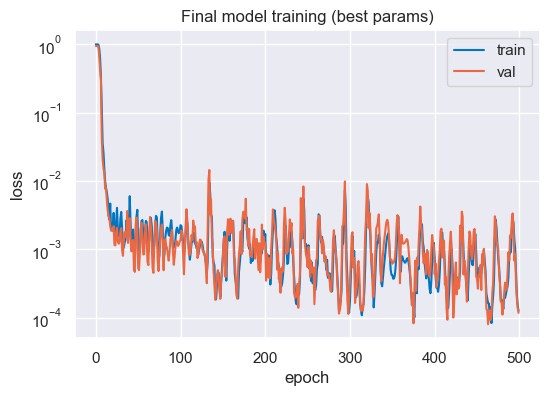

In [59]:
# Train a final model with best params and set it as `model`
activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}
loss_map = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}
optimizer_map = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

best = study.best_params
print("Using best params:", best)

model = FNN(
    input_size,
    output_size,
    hidden_features=best["hidden_size"],
    activation_function=activation_map[best["activation"]]
 ).to(device)

optimizer = optimizer_map[best["optimizer"]](model.parameters(), lr=best["learning_rate"]) 
loss_function = loss_map[best["loss"]]

# Train and keep the best checkpoint (lowest validation loss)
import copy
from datetime import datetime
import os

FINAL_EPOCHS = 500
train_curve, val_curve = [], []
best_val = float("inf")
best_epoch = None
best_state = None
min_delta = 1e-6

# Create save dir and persist normalizers (same idea as the PINN notebooks)
save_dir = os.path.join("models")
os.makedirs(save_dir, exist_ok=True)

torch.save({
    "x_mean": float(x_normalizer.normmean),
    "x_std": float(x_normalizer.normstd),
    "t_mean": float(t_normalizer.normmean),
    "t_std": float(t_normalizer.normstd),
    "f_mean": float(f_normalizer.normmean),
    "f_std": float(f_normalizer.normstd),
    "u_mean": float(u_normalizer.normmean),
    "u_std": float(u_normalizer.normstd),
}, os.path.join(save_dir, "normalizers_FNN.pt"))

best_weights_path = os.path.join(save_dir, "best_fnn.pt")
best_weights_fallback_path = os.path.join(save_dir, "best_fnn_temp.pt")

for epoch in range(1, FINAL_EPOCHS + 1):
    tr = train_epoch(model, train_loader, optimizer, loss_function)
    vl = evaluation(model, validation_loader, loss_function)
    train_curve.append(tr)
    val_curve.append(vl)

    # Save-on-improvement (PINN-style): makes the best model robust to interruptions
    if vl < best_val - min_delta:
        best_val = vl
        best_epoch = epoch
        best_state = copy.deepcopy(model.state_dict())

        try:
            torch.save(model.state_dict(), best_weights_path)
        except Exception as e:
            print(f"Primary save failed: {e}")
            torch.save(model.state_dict(), best_weights_fallback_path)

    if epoch % 20 == 0:
        print(f"final epoch {epoch}: train={tr:.4f}, val={vl:.4f}")

# Restore best weights (so `model` is the best model, not just the last epoch)
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best model from epoch {best_epoch} (val={best_val:.6f})")

# Save best model checkpoint (includes normalizers so evaluation can run standalone)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(save_dir, f"fnn_best_{ts}.pt")

checkpoint = {
    "model_state_dict": model.state_dict(),
    "best_val": float(best_val),
    "best_epoch": int(best_epoch) if best_epoch is not None else None,
    "best_params": dict(best),
    "input_size": int(input_size),
    "output_size": int(output_size),
    "data": {"L": float(np.pi), "t_end": float(t_end)},
    "normalizers": {
        "x_mean": float(x_normalizer.normmean),
        "x_std": float(x_normalizer.normstd),
        "t_mean": float(t_normalizer.normmean),
        "t_std": float(t_normalizer.normstd),
        "f_mean": float(f_normalizer.normmean),
        "f_std": float(f_normalizer.normstd),
        "u_mean": float(u_normalizer.normmean),
        "u_std": float(u_normalizer.normstd),
    },
}
torch.save(checkpoint, save_path)
print(f"Saved best model to: {save_path}")

# Optional: quick plot of curves
plt.figure(figsize=(6,4))
plt.plot(train_curve, label="train")
plt.plot(val_curve, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Final model training (best params)")
plt.legend();

Found rolling best weights: models\best_fnn.pt
f_relL2_%: 0.9385
u_relL2_%: 0.9384
f_MAPE_%: 6.2846
u_MAPE_%: 6.2867


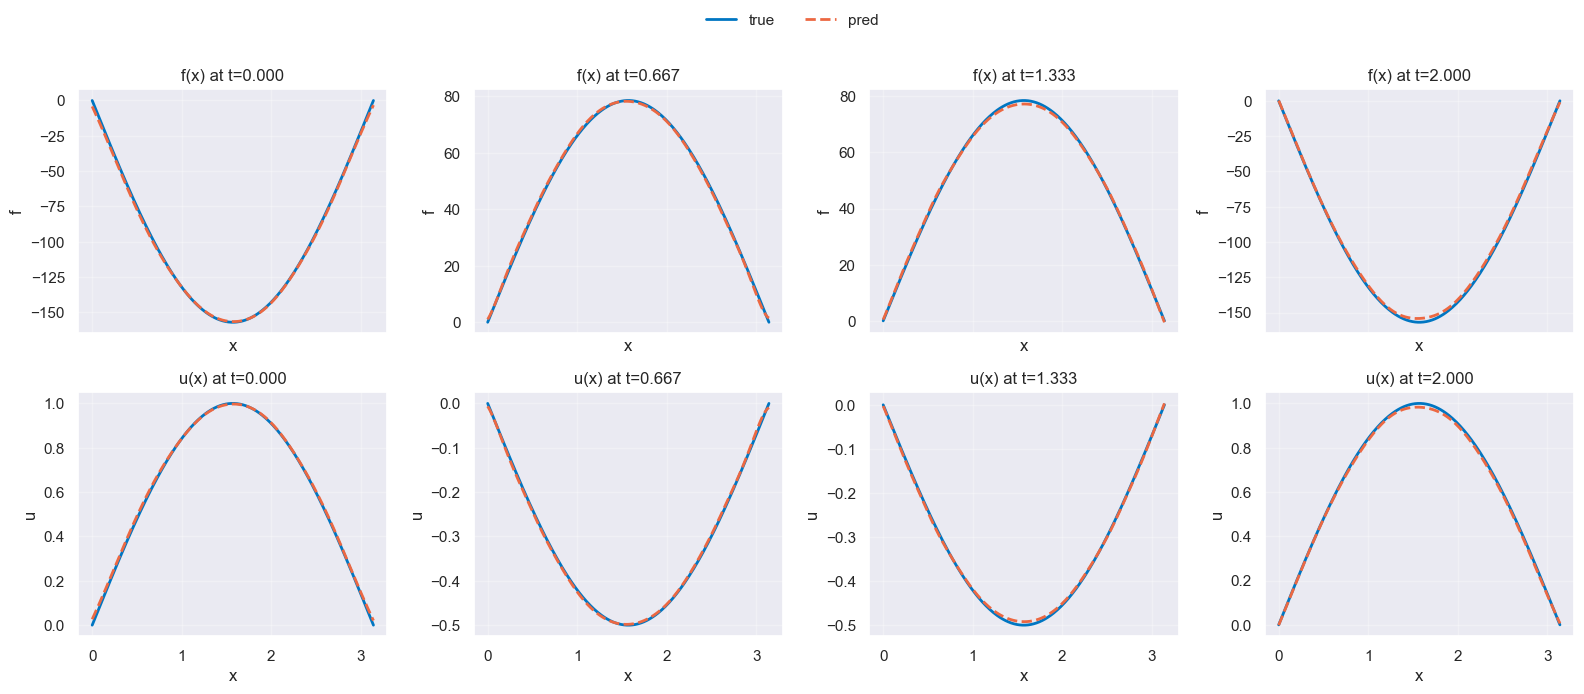

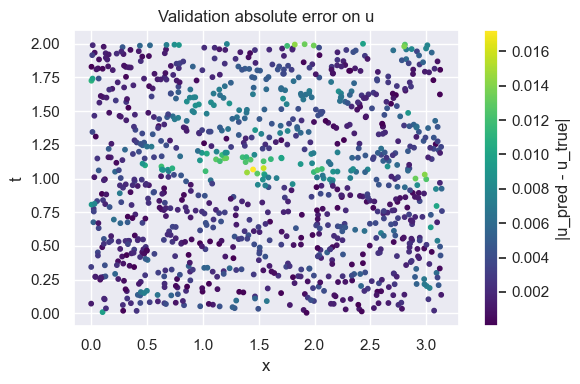

In [60]:
# Load best saved model, plot predictions, and compute relative errors
import os, glob
import torch
import matplotlib.pyplot as plt

ckpt_dir = os.path.join("models")
best_weights_path = os.path.join(ckpt_dir, "best_fnn.pt")
best_norms_path = os.path.join(ckpt_dir, "normalizers_FNN.pt")

# --- Helper normalizer that can be reconstructed from saved mean/std ---
class FixedNormalizer:
    def __init__(self, mean, std):
        self.normmean = torch.as_tensor(mean, dtype=torch.float32)
        self.normstd = torch.as_tensor(std, dtype=torch.float32)

    def normalize(self, data):
        mean = self.normmean.to(device=data.device, dtype=data.dtype)
        std = self.normstd.to(device=data.device, dtype=data.dtype)
        return (data - mean) / std

    def denormalize(self, data):
        mean = self.normmean.to(device=data.device, dtype=data.dtype)
        std = self.normstd.to(device=data.device, dtype=data.dtype)
        return data * std + mean

# Prefer using the rolling best weights if present; otherwise fall back to the newest full checkpoint
checkpoint = None
used_weights_only = False

if os.path.isfile(best_weights_path):
    print("Found rolling best weights:", best_weights_path)
    used_weights_only = True
    try:
        best_state_dict = torch.load(best_weights_path, map_location=device, weights_only=True)
    except TypeError:
        best_state_dict = torch.load(best_weights_path, map_location=device)
else:
    ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "fnn_best_*.pt")), key=os.path.getmtime)
    if len(ckpt_paths) == 0:
        raise FileNotFoundError(
            f"No checkpoints found in {ckpt_dir}. Run the final training cell first."
        )
    ckpt_path = ckpt_paths[-1]

    # Prefer weights-only load (safer). Fall back to full load for older checkpoints made before we cast metadata to pure Python types.
    try:
        checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        checkpoint = torch.load(ckpt_path, map_location=device)
    except Exception as e:
        print("weights_only load failed, retrying full load:", repr(e))
        checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    print("Loaded checkpoint:", ckpt_path)

# Resolve hyperparameters / architecture
if used_weights_only:
    # Need params to rebuild the model. Prefer the study results if available, else fall back to `best` if it exists.
    if "study" in globals():
        best = study.best_params
    elif "best" in globals():
        best = best
    else:
        raise RuntimeError(
            "Found best_fnn.pt (weights only), but no Optuna params in memory. "
            "Run the Optuna tuning + final training cells first, or load a full fnn_best_*.pt checkpoint."
        )
    input_size = int(globals().get("input_size", 3))
    output_size = int(globals().get("output_size", 2))
else:
    best = checkpoint.get("best_params", None)
    if best is None:
        raise KeyError("Checkpoint missing 'best_params'.")
    input_size = int(checkpoint.get("input_size", globals().get("input_size", 3)))
    output_size = int(checkpoint.get("output_size", globals().get("output_size", 2)))

activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}
model_loaded = FNN(
    input_size=input_size,
    output_size=output_size,
    hidden_features=best["hidden_size"],
    activation_function=activation_map[best["activation"]],
).to(device)

if used_weights_only:
    model_loaded.load_state_dict(best_state_dict)
else:
    model_loaded.load_state_dict(checkpoint["model_state_dict"])
model_loaded.eval()

# Load normalizers from checkpoint (preferred) or from the standalone normalizers file
norms = None
if checkpoint is not None:
    norms = checkpoint.get("normalizers", None)
if norms is None and os.path.isfile(best_norms_path):
    try:
        norms = torch.load(best_norms_path, map_location="cpu", weights_only=True)
    except TypeError:
        norms = torch.load(best_norms_path, map_location="cpu")

if norms is None:
    raise FileNotFoundError(
        "No normalizers found in checkpoint and normalizers_FNN.pt not found. "
        "Run the final training cell to (re)create normalizers_FNN.pt."
    )

# Override the in-kernel normalizers so the rest of this cell is standalone
x_normalizer = FixedNormalizer(norms["x_mean"], norms["x_std"])
t_normalizer = FixedNormalizer(norms["t_mean"], norms["t_std"])
f_normalizer = FixedNormalizer(norms["f_mean"], norms["f_std"])
u_normalizer = FixedNormalizer(norms["u_mean"], norms["u_std"])

# Predict on validation set (normalized space) -> used for metrics
with torch.no_grad():
    y_pred_norm = model_loaded(inputs_val.to(device)).cpu()
y_true_norm = outputs_val.cpu()

# Denormalize to physical units
f_pred = f_normalizer.denormalize(y_pred_norm[:, 0])
u_pred = u_normalizer.denormalize(y_pred_norm[:, 1])
f_true = f_normalizer.denormalize(y_true_norm[:, 0])
u_true = u_normalizer.denormalize(y_true_norm[:, 1])

# Relative error metrics (percent)
def rel_l2_percent(pred, true, eps=1e-12):
    return (torch.linalg.norm(pred - true) / (torch.linalg.norm(true) + eps) * 100).item()

def mean_abs_pct_error(pred, true, eps=1e-8):
    return (torch.mean(torch.abs((pred - true) / (true + eps))) * 100).item()

metrics = {
    "f_relL2_%": rel_l2_percent(f_pred, f_true),
    "u_relL2_%": rel_l2_percent(u_pred, u_true),
    "f_MAPE_%": mean_abs_pct_error(f_pred, f_true),
    "u_MAPE_%": mean_abs_pct_error(u_pred, u_true),
}
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# --- Smooth curves: evaluate on a clean (x, t) grid ---
# Your validation set is random in (x,t), so "nearest-time" slices look noisy.
# For clean sine-wave plots, evaluate the model on a uniform x-grid at chosen times.
x_min = 0.0
x_max = float(torch.pi)
n_x = 300
x_grid = torch.linspace(x_min, x_max, steps=n_x, dtype=torch.float32)

# Choose time instants to plot
n_times = 4
times = torch.linspace(0.0, float(t_end), steps=n_times, dtype=torch.float32)

def true_u_torch(x, t):
    return torch.sin(x) * torch.cos(4 * torch.pi * t)

def true_f_torch(x, t):
    return (1 - 16 * torch.pi**2) * torch.sin(x) * torch.cos(4 * torch.pi * t)

fig, axes = plt.subplots(2, n_times, figsize=(4 * n_times, 7), sharex=True)
if n_times == 1:
    axes = axes.reshape(2, 1)

for j, t0 in enumerate(times):
    t_grid = torch.full_like(x_grid, fill_value=t0)
    bias = torch.ones_like(x_grid)

    # Normalize inputs using the same normalizers as training
    x_in = x_normalizer.normalize(x_grid)
    t_in = t_normalizer.normalize(t_grid)
    inp = torch.stack([x_in, t_in, bias], dim=1).to(device)

    with torch.no_grad():
        y_hat_norm = model_loaded(inp).cpu()

    f_hat = f_normalizer.denormalize(y_hat_norm[:, 0])
    u_hat = u_normalizer.denormalize(y_hat_norm[:, 1])

    # True (analytic) curves
    u_t = true_u_torch(x_grid, t0)
    f_t = true_f_torch(x_grid, t0)

    axes[0, j].plot(x_grid.numpy(), f_t.numpy(), label="true", lw=2)
    axes[0, j].plot(x_grid.numpy(), f_hat.numpy(), label="pred", lw=2, ls="--")
    axes[0, j].set_title(f"f(x) at t={t0.item():.3f}")
    axes[0, j].set_xlabel("x")
    axes[0, j].set_ylabel("f")
    axes[0, j].grid(True, alpha=0.3)

    axes[1, j].plot(x_grid.numpy(), u_t.numpy(), label="true", lw=2)
    axes[1, j].plot(x_grid.numpy(), u_hat.numpy(), label="pred", lw=2, ls="--")
    axes[1, j].set_title(f"u(x) at t={t0.item():.3f}")
    axes[1, j].set_xlabel("x")
    axes[1, j].set_ylabel("u")
    axes[1, j].grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=(0, 0, 1, 0.93))
plt.show()

# Optional: error vs. (x, t) scatter on u (computed on random validation samples)
x_val = x_normalizer.denormalize(inputs_val[:, 0].cpu())
t_val = t_normalizer.denormalize(inputs_val[:, 1].cpu())
err_u = (u_pred - u_true).abs()
plt.figure(figsize=(6, 4))
sc = plt.scatter(x_val.numpy(), t_val.numpy(), c=err_u.numpy(), s=10, cmap="viridis")
plt.colorbar(sc, label="|u_pred - u_true|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Validation absolute error on u")
plt.tight_layout()
plt.show()